# Logistic Regression pipeline

In [2]:
import pandas as pd 

dataframe = pd.read_csv("SBAnational.csv", low_memory=False)
#dataframe.isna().sum()

## 1. Drop columns

In [3]:
X = dataframe.drop('LoanNr_ChkDgt', axis=1)
X = X.drop('Name', axis=1)
X = X.drop('City', axis=1)
# State included
X = X.drop('Zip', axis=1)
X = X.drop('Bank', axis=1)
X = X.drop('BankState', axis=1)
# NAICS included (2 first chars )
X = X.drop('ApprovalDate', axis=1)
# ApprovalFY included 
# Term (nombre de mois - à mettre en rapport avec le GrAppv ?) included
# NoEmp, NewExist , CreateJob, RetainedJob, FranchiseCode, UrbanRural, RevLineCr include 
# LowDoc (include 'y' only) included
X = X.drop('ChgOffDate', axis=1) # (explicit end on simulation?) : included 
X = X.drop('DisbursementDate', axis=1)  
X = X.drop('DisbursementGross', axis=1)  
X = X.drop('BalanceGross', axis=1)  # 14 valeurs seulement différentes de zéro  ?
# MIS_Status : INCLUDED !!! because it is Y
X = X.drop('ChgOffPrinGr', axis=1)
# GrAppv : included
# SBA_Appv : included



#X.isna().sum()

## 2. Convert data types
    (and remove lines)

In [4]:
for column_name in X.columns.values :
    print(f"{column_name} : {X[column_name].dtype}")

State : object
NAICS : int64
ApprovalFY : object
Term : int64
NoEmp : int64
NewExist : float64
CreateJob : int64
RetainedJob : int64
FranchiseCode : int64
UrbanRural : int64
RevLineCr : object
LowDoc : object
MIS_Status : object
GrAppv : object
SBA_Appv : object


In [5]:
X["RevLineCr"].value_counts()

RevLineCr
N    420288
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
,         1
3         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [6]:
import conversion_functions as conv
import math

print (f"Before : {X.shape[0]} lines")

explanable_X = pd.DataFrame(X)

explanable_X["State"] = explanable_X["State"].apply(lambda x : conv.get_state_code(x))
#explanable_X = explanable_X[explanable_X["State"]!=0]

explanable_X["NAICS"] = explanable_X["NAICS"].apply(lambda x : conv.get_NAICS_data(x))
#explanable_X = explanable_X[explanable_X["NAICS"]!=0]

explanable_X["ApprovalFY"] = explanable_X["ApprovalFY"].apply(lambda x : conv.get_ApprovalFY_data(x)) 
mean_dataframe = explanable_X[ explanable_X["ApprovalFY"] !=50]
mean_value = mean_dataframe["ApprovalFY"].mean()
explanable_X.loc[explanable_X['ApprovalFY'] == 50, 'ApprovalFY'] = math.ceil(mean_value)

explanable_X["NewExist"] = explanable_X["NewExist"].apply(lambda x : conv.get_NewExist_data(x)) 
explanable_X["FranchiseCode"] = explanable_X["FranchiseCode"].apply(lambda x : conv.get_FranchiseCode_data(x)) 

explanable_X = explanable_X.drop("UrbanRural", axis=1)

explanable_X["RevLineCr"] = explanable_X["RevLineCr"].apply(lambda x : conv.get_RevLineCr_data(x)) 
explanable_X["LowDoc"] = explanable_X["LowDoc"].apply(lambda x : conv.get_LowDoc_data(x)) 

explanable_X["GrAppv"] = explanable_X["GrAppv"].apply(lambda x : conv.get_GrAppv_value(x)) 
mean_dataframe = explanable_X[ explanable_X["GrAppv"] !=0]
mean_value = mean_dataframe["GrAppv"].mean()
explanable_X.loc[explanable_X['GrAppv'] == 0, 'ApprovalFY'] = math.ceil(mean_value)

explanable_X = explanable_X[ explanable_X["GrAppv"] !=0] 

explanable_X = explanable_X.drop("SBA_Appv", axis = 1)
# explanable_X["SBA_Appv"] = explanable_X["SBA_Appv"].apply(lambda x : conv.get_SBA_Appv_value(x)) 
# explanable_X = explanable_X[ explanable_X["SBA_Appv"] !=0] 

explanable_X = explanable_X[(explanable_X["MIS_Status"]=="P I F") |
                              (explanable_X["MIS_Status"]=="CHGOFF")]

explanable_X["MIS_Status"] = explanable_X["MIS_Status"].apply(lambda x : 1.0 if x == "CHGOFF" else 0.0)

print (f"After : {explanable_X.shape[0]} lines")


Before : 899164 lines
After : 897167 lines


In [7]:
for column_name in explanable_X.columns.values :
    print(f"{column_name} : {explanable_X[column_name].dtype}")

State : int64
NAICS : int64
ApprovalFY : int64
Term : int64
NoEmp : int64
NewExist : int64
CreateJob : int64
RetainedJob : int64
FranchiseCode : int64
RevLineCr : int64
LowDoc : int64
MIS_Status : float64
GrAppv : int64


## 3. Create pipeline

In [9]:
import numpy as np
import pandas as pd 

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, LabelBinarizer, OneHotEncoder, Binarizer, FunctionTransformer, PolynomialFeatures,MinMaxScaler



In [10]:
preprocessor = make_pipeline(  
    make_column_transformer(
        # LoanNr_ChkDgt, Name , City : excluded
        (OneHotEncoder(), ["State"]), 
        # Zip , Bank , BankState : excluded
        (OneHotEncoder(), ["NAICS"]), #included (2 first chars )
        # ApprovalDate : excluded
        (StandardScaler(), ["ApprovalFY"]),
        (StandardScaler(), ["Term"]), 
        (StandardScaler(), ["NoEmp"]),
        (StandardScaler(), ["NewExist"]),
        (StandardScaler(), ["CreateJob"]),
        (StandardScaler(), ["RetainedJob"]),
        (Binarizer(), ["FranchiseCode"]),
        #Binarizer("UrbanRural", threshold=1.5),
        (OneHotEncoder(), ["RevLineCr"]),
        (Binarizer(), ["LowDoc"]),
        # SimpleImputer("ChgOffDate"), # explicit end on simulation
        # DisbursementDate, DisbursementGross , BalanceGross ( 14 valeurs seulement différentes de zéro  ?)
        # MIS_Status : Excluded because it is Y !!!
        # ChgOffPrinGr : excluded
        (StandardScaler(), ["GrAppv"]), 
        #(StandardScaler(),["SBA_Appv"]),  
        remainder='passthrough'))

In [11]:
from sklearn.pipeline import Pipeline
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=200, solver='liblinear', random_state=0)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    #('vectorizer', TfidfVectorizer()), 
    ('model', log_reg_model)])

pipeline


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder-1',
                                                                   OneHotEncoder(),
                                                                   ['State']),
                                                                  ('onehotencoder-2',
                                                                   OneHotEncoder(),
                                                                   ['NAICS']),
                                                                  ('standardscaler-1',
                                                                   StandardScaler(),
                                                                   ['ApprovalFY']),
                                                                  ('standardscaler-2',
                                                                   StandardScaler(),
                                                                   ['Term']),
                                                                  ('standardscaler-3',
                                                                   StandardScale...
                                                                   StandardScaler(),
                                                                   ['CreateJob']),
                                                                  ('standardscaler-6',
                                                                   StandardScaler(),
                                                                   ['RetainedJob']),
                                                                  ('binarizer-1',
                                                                   Binarizer(),
                                                                   ['FranchiseCode']),
                                                                  ('onehotencoder-3',
                                                                   OneHotEncoder(),
                                                                   ['RevLineCr']),
                                                                  ('binarizer-2',
                                                                   Binarizer(),
                                                                   ['LowDoc']),
                                                                  ('standardscaler-7',
                                                                   StandardScaler(),
                                                                   ['GrAppv'])]))])),
                ('model',
                 LogisticRegression(max_iter=200, random_state=0,
                                    solver='liblinear'))])

In [12]:
y = explanable_X["MIS_Status"]
print(y)
explanable_X = explanable_X.drop("MIS_Status", axis = 1)


0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
899159    0.0
899160    0.0
899161    0.0
899162    1.0
899163    0.0
Name: MIS_Status, Length: 897167, dtype: float64


In [13]:
y.value_counts()

MIS_Status
0.0    739609
1.0    157558
Name: count, dtype: int64

In [ ]:
explanable_X

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(explanable_X, y, shuffle=True, train_size=0.8, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

# print(y.value_counts())
# print(f"X.X    {y.shape[0]}")


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder-1',
                                                                   OneHotEncoder(),
                                                                   ['State']),
                                                                  ('onehotencoder-2',
                                                                   OneHotEncoder(),
                                                                   ['NAICS']),
                                                                  ('standardscaler-1',
                                                                   StandardScaler(),
                                                                   ['ApprovalFY']),
                                                                  ('standardscaler-2',
                                                                   StandardScaler(),
                                                                   ['Term']),
                                                                  ('standardscaler-3',
                                                                   StandardScale...
                                                                   StandardScaler(),
                                                                   ['CreateJob']),
                                                                  ('standardscaler-6',
                                                                   StandardScaler(),
                                                                   ['RetainedJob']),
                                                                  ('binarizer-1',
                                                                   Binarizer(),
                                                                   ['FranchiseCode']),
                                                                  ('onehotencoder-3',
                                                                   OneHotEncoder(),
                                                                   ['RevLineCr']),
                                                                  ('binarizer-2',
                                                                   Binarizer(),
                                                                   ['LowDoc']),
                                                                  ('standardscaler-7',
                                                                   StandardScaler(),
                                                                   ['GrAppv'])]))])),
                ('model',
                 LogisticRegression(max_iter=200, random_state=0,
                                    solver='liblinear'))])

In [16]:
score = pipeline.score(X_test, y_test)
print(f'Précision du modèle : {score:.2f}')

Précision du modèle : 0.85


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher les résultats
print(f"Exactitude du modèle (Accuracy) : {accuracy * 100:.2f}%")
print("Matrice de confusion :")
print(conf_matrix)


Exactitude du modèle (Accuracy) : 84.91%
Matrice de confusion :
[[144131   3791]
 [ 23284   8228]]


In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91    147922
         1.0       0.68      0.26      0.38     31512

    accuracy                           0.85    179434
   macro avg       0.77      0.62      0.65    179434
weighted avg       0.83      0.85      0.82    179434



In [26]:
# Importance des features
log_reg:LogisticRegression = pipeline.named_steps['model']

# Récupérer les coefficients de la régression logistique

columnTransformer:ColumnTransformer  = pipeline.named_steps['preprocessor'][0]

# Afficher les colonnes transformées

feature_names = []
remainder_num=0
for transformer_name, transformer, columns in columnTransformer.transformers_:
    if str(transformer_name).startswith("onehotencoder") :
        num = 0
        onehot:OneHotEncoder = transformer
        column_name = columns[0]
        for n in transformer.get_feature_names_out():
            feature_names.append(f"{columns[0]}_{num}")
            num+=1
    else :
        if len(columns) == 1 :
            name = columns[0]
            if name == "Term" :
                name = "Echéance"
            
            feature_names.append(name) 
        else:
            num = 0
            for column in columns : 
                feature_names.append(f"other_{column}_{num}")
                num+=1
            

coefficients = log_reg.coef_[0]

print(f"feature names : {len(feature_names)}")
print(f"Coefficients : {len(coefficients)}")


feature names : 90
Coefficients : 90


In [27]:

# Créer un DataFrame avec les features et leurs coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Trier par coefficient (en valeur absolue) pour voir les features les plus importantes
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

# Afficher les résultats
#print(feature_importance_sorted[['Feature', 'Coefficient']])

# afficher les résultats sans le state et le naics

selection = feature_importance_sorted[ ~(feature_importance_sorted["Feature"].str.startswith("State") | feature_importance_sorted["Feature"].str.startswith("NAICS") )]
print(selection[['Feature', 'Coefficient']])
   


          Feature  Coefficient
78       Echéance    -2.068829
87    RevLineCr_3    -0.915071
88         LowDoc    -0.799533
79          NoEmp    -0.589427
84    RevLineCr_0    -0.562399
85    RevLineCr_1    -0.467739
81      CreateJob     0.344494
77     ApprovalFY     0.327787
82    RetainedJob    -0.231118
89         GrAppv     0.182975
80       NewExist     0.051722
86    RevLineCr_2     0.034942
83  FranchiseCode     0.026201


In [21]:
import shap

transformed_X_train = pipeline.named_steps['preprocessor'].transform(X_train)

# Initialiser SHAP explainer
# Créer un explainer avec LinearExplainer en passant le modèle et les feature_names
explainer = shap.LinearExplainer(pipeline.named_steps['model'], transformed_X_train, feature_names=feature_names)


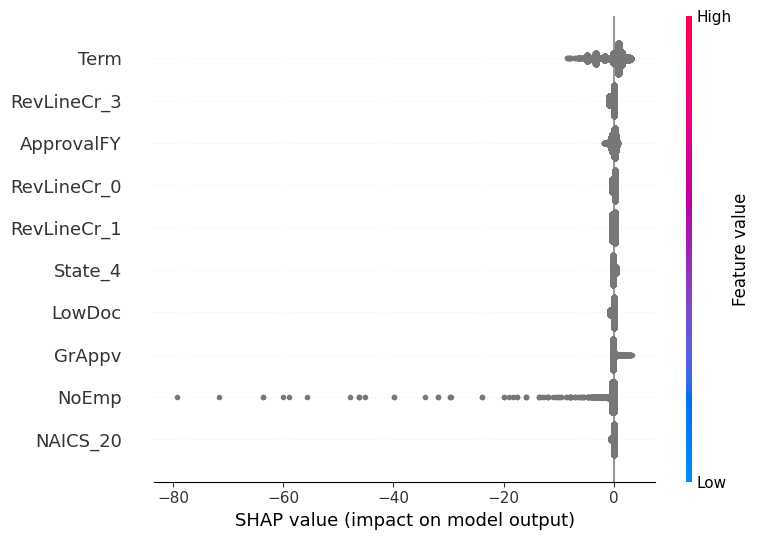

In [22]:
transformed_X_test = pipeline.named_steps['preprocessor'].transform(X_test)

# Calcul des SHAP values sur le jeu de test
shap_values = explainer.shap_values(transformed_X_test)

# Affichage du summary plot
shap.summary_plot(shap_values, transformed_X_test, feature_names=feature_names, max_display=10)